In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
import numpy as np
from source.code import utils

2023-04-16 11:33:21.248487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 11:33:21.373746: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 11:33:21.917689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/media/hdd/nzliao/2027/software/miniconda3/envs/tensorflow/lib/
2023-04-16 11:33:21.917776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'

In [17]:
utils.gpu_limitation_config(memory=12)

1. 在权重衰退中，可以尝试更改不同的正则化参数 $\lambda$，然后绘制训练集损失和验证集损失随着 $\lambda$ 的变化情况，你应该可以观察到过拟合，欠拟合现象

In [18]:
#数据
n_train, n_valid = 20, 100 # 训练集和测试集大小
input_size = 200
true_w, trub_b = tf.ones([input_size,1])*0.01, 0.05
# 生成训练集
x_train = tf.random.normal((n_train,input_size)) * 0.1
y_train = x_train @ true_w + trub_b + tf.random.normal((n_train,1),stddev=0.01)
# 生成验证集
x_valid = tf.random.normal((n_valid,input_size)) * 0.1
y_valid = x_valid @ true_w + trub_b + tf.random.normal((n_valid,1),stddev=0.01)

In [19]:
class LinearRegressionAPI(tf.keras.Model):
    def __init__(self, lamda : float=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dense = Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=lamda))
    
    def call(self, inputs):
        return self.dense(inputs)

In [20]:
def train_of_regularize_of_API(model, x_train : tf.Tensor, y_train : tf.Tensor, x_valid : tf.Tensor, y_valid : tf.Tensor,
                               batch_size : int=32, epochs : int=100,lr : float=0.1, verbose : int=5):
    #优化器和损失函数
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    mse = tf.keras.losses.MeanSquaredError()

    #动画演示
    animator = utils.Animator(xlabel="Epochs",legend=["train loss","valid loss"],
                              yscale="linear",xlim=[0,epochs])

    #开始迭代
    for epoch in range(epochs):
        #数据分批取出
        batch_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size=batch_size).shuffle(buffer_size=batch_size)

        for x_batch, y_batch in batch_data:
            #梯度下降，追踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch)
                loss = mse(y_batch, y_hat) + model.losses
            
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            optimizer.apply_gradients(zip(grads, weights))

        # 计算评估指标，添加到动画
        if epoch == 0 or (epoch+1)%verbose == 0: 
            y_train_hat = model(x_train)
            y_test_hat = model(x_valid)

            train_loss = mse(y_train,y_train_hat).numpy()
            valid_loss = mse(y_valid,y_test_hat).numpy()
            animator.add(epoch+1,[train_loss,valid_loss])

    return model

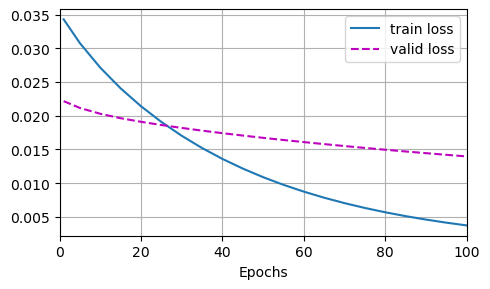

In [21]:
#过拟合
model = LinearRegressionAPI(lamda=0.02)
model = train_of_regularize_of_API(model,x_train,y_train,x_valid,y_valid,batch_size=5,lr=0.01,epochs=100,verbose=5)

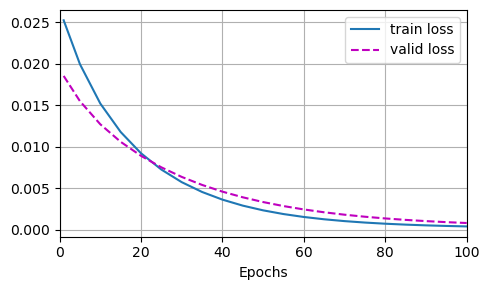

In [22]:
#正常
model = LinearRegressionAPI(lamda=0.2)
model = train_of_regularize_of_API(model,x_train,y_train,x_valid,y_valid,batch_size=5,lr=0.01,epochs=100,verbose=5)

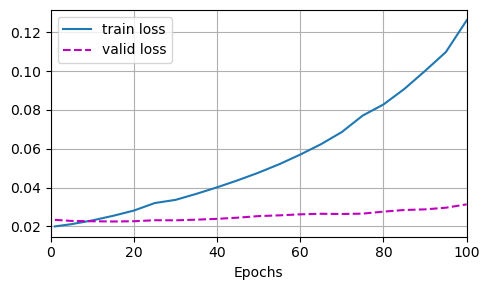

In [23]:
#欠拟合
model = LinearRegressionAPI(lamda=100)
model = train_of_regularize_of_API(model,x_train,y_train,x_valid,y_valid,batch_size=5,lr=0.01,epochs=100,verbose=5)

2. 在某一个固定的验证数据集上调整，寻找最优的权重衰退正则化超参数 $\lambda$ 会**造成另一种过拟合**，解释这里存在的过拟合问题

因为这里寻找到的$\lambda$只在验证集上是最优(或较优)的超参数，当验证集数据分布和总体差距较大时，该$\lambda$在实际数据表现上不好是非常有可能的，这也属于是一种过拟合

3. 在使用keras的`Dropout()`层训练模型时，比较调用模型的`call()`方法时，设置`training = True`和不设置`training`参数的结果

In [24]:
class LinearRegressionDropoutAPI(tf.keras.Model):
    def __init__(self, num_hiddens : int=64, dropout : float=0.2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dense1 = Dense(num_hiddens,activation='tanh')
        self.dense2 = Dense(1)
        self.dropout1 = tf.keras.layers.Dropout(rate=dropout)
    
    def call(self, inputs, training=None, mask=None):
        x = self.dense1(inputs)
        x = self.dropout1(x)  # API 只会在训练的时候启用 Dropout
        return self.dense2(x)

In [25]:
def train_dropout(model, X_train : tf.Tensor, y_train : tf.Tensor, X_valid : tf.Tensor, y_valid : tf.Tensor, 
                  batch_size : int=32, epochs : int=200, lr : float=0.01, verbose : int=5):
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) # 创建优化器
    mse = tf.keras.losses.MeanSquaredError() # 实例化损失函数

    animator = utils.Animator(xlabel="Epochs",legend=["train loss","valid loss"],
                              yscale="linear",xlim=[0,epochs]) # 创建动画实例

    for epoch in range(epochs):
        # 使用 Tensorflow API 创建批量数据的生成器
        batch_data = tf.data.Dataset.from_tensor_slices((X_train,y_train)).\
            batch(batch_size=batch_size).shuffle(buffer_size=batch_size)
        
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch,training=True) # 训练时，使用 Dropout
                loss = mse(y_batch,y_hat)
            
            # 选取参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights)) # 直接调用优化器 API
        
        # 计算评估指标，添加到动画
        if epoch == 0 or (epoch+1)%verbose == 0: # 每 verbose 次更新一次
            y_train_hat = model(X_train)
            y_valid_hat = model(X_valid)

            train_loss = mse(y_train,y_train_hat).numpy()
            valid_loss = mse(y_valid,y_valid_hat).numpy()
            animator.add(epoch+1,[train_loss,valid_loss])
        
    return model

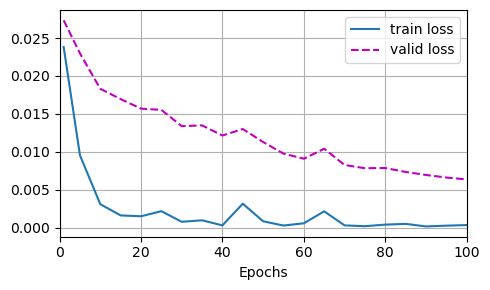

In [28]:
#创建+训练模型
model = LinearRegressionDropoutAPI(dropout=0.5)
model = train_dropout(model,x_train,y_train,x_valid,y_valid,batch_size=4,lr=0.05,epochs=100,verbose=5)

In [29]:
#设置training=True和不设置
(model.call(x_train,training=True) == model.call(x_train)).numpy().all()

True

实验发现，设置training=True和不设置training结果一致，说明keras的API能够判断模型是否处于训练状态从而决定是否使用dropout

4. 查阅相关资料，简单说说Kaiming初始化是如何进行的

Kaiming初始化是对Xavier初始化的一种改进。在Xavier初始化中，我们并未考虑激活函数带来的影响：在Xavier初始化的推导过程中，相当于假设了激活函数是线性的且激活值关于0对称，而并未考虑非线性激活函数，这是不合理的(因为线性激活函数相当于没有激活函数)。Kaiming初始化正是为了解决这个问题而作出的改进。

Kaiming初始化的目标是，前向过程中状态值的方差稳定，反向传播时激活值的方差稳定。

Kaiming初始化的条件受激活函数的选取而改变，一般使用推导较为简单的Relu激活函数。

类似Xavier初始化的假设和推导，可得前向过程的Kaiming初始化的公式：
$$
W～N(0,\frac{2}{n_{in}})
$$

或
$$
W～U\left( -\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}} \right)
$$

同理，反向传播的Kaiming初始化公式：
$$
W～N(0,\frac{2}{n_{out}})
$$

或
$$
W～U\left( -\sqrt{\frac{6}{n_{out}}}, \sqrt{\frac{6}{n_{out}}} \right)
$$

取两者方差的调和平均数，得到最终的Kaiming初始化公式：
$$
W～N(0,\frac{4}{n_{in} + n_{out}})
$$

或
$$
W～U\left( -\sqrt{\frac{12}{n_{in} + n_{out}}}, \sqrt{\frac{12}{n_{in} + n_{out}}} \right)
$$